In [2]:
import pandas as pd
import os.path
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns
#import pingouin as pg
import openpyxl
import re
class StopCell(Exception): # a custom (mute) exception to exit cells programmatically ("raise StopCell")
    def _render_traceback_(self):
        pass

<mark> Dataframes :
- data_df : dataframe des behavioural data
- data_df_summary : dataframe des summary meca data
- filtered_df : summary meca data sans sujets practice
- filtered_df2 : summary meca data sans duplicates
- missing_df : dataframe des trials qui n'existent pas
- filtered_df2[mask] : dataframe sans valeurs outliers
- outlier_values : dataframe des essais avec au moins une valeur outlier
- df_result : behavioural data + summary meca data
- same_same_df : essais same-same

# Analysis Tactile Revcor
&copy; Céline Vanney, Etienne Louyot, JJ Aucouturier, PH Cornuault, Luc Carpentier


## Behavioural data

### Load Behavioural data

In [3]:
for file in glob.glob("./data/behaviour/*results*.csv"):
    print(file)

./data/behaviour\221110_08.22_results_subj6_soft.csv
./data/behaviour\221110_10.41_results_subj7_soft.csv
./data/behaviour\221110_14.16_results_subj8_soft.csv
./data/behaviour\221115_10.24_results_subj9_rug.csv
./data/behaviour\221116_15.47_results_subj10_rug.csv
./data/behaviour\221117_10.16_results_subj11_soft.csv
./data/behaviour\221117_15.45_results_subj12_rug.csv
./data/behaviour\221118_10.35_results_subj13_rug.csv
./data/behaviour\221121_08.55_results_subj14_soft.csv
./data/behaviour\221121_15.48_results_subj15_soft.csv
./data/behaviour\221122_08.42_results_subj16_soft.csv
./data/behaviour\221122_10.23_results_subj17_soft.csv
./data/behaviour\221122_14.05_results_subj18_soft.csv
./data/behaviour\221122_15.52_results_subj19_soft.csv
./data/behaviour\221123_10.28_results_subj20_soft.csv
./data/behaviour\221123_13.37_results_subj21_soft.csv
./data/behaviour\221124_13.36_results_subj22_soft.csv
./data/behaviour\221124_15.54_results_subj23_soft.csv
./data/behaviour\221125_09.06_result

#### Fix condition field & filename

Result files from participant 7 onwards include a `condition` field, and have their condition in the filename. Correct this for earlier participants. 

In [6]:
if True: raise StopCell

conditions = {'1':'rug', '2':'soft', '3':'soft',
             '4':'soft', '5':'soft','6':'soft'}

for participant in [6]: 
    
    # get participant file
    file = glob.glob("./data/behaviour/*results_subj%d*.csv"%participant)[0]
    
    # add condition in pandas
    condition = conditions[str(participant)]
    participant_data = pd.read_csv(file)
    participant_data['condition'] = condition
    
    # and save as new csv file with updated filename
    name, ext = os.path.splitext(os.path.basename(file))
    updated_filename = './data/behaviour/' + name + '_'+ condition + ext
    participant_data.to_csv(updated_filename,index=False)

#### Load all data

In [4]:
data_files = glob.glob("./data/behaviour/*_results_*.csv")
print("got %d behavioural files"%len(data_files))
data_df = pd.DataFrame()
for data_file in data_files:
    participant_data_df = pd.read_csv(data_file, sep = ',', decimal='.', header='infer')
    data_df = pd.concat([data_df, participant_data_df], ignore_index=True)
print('dataframe has %d subjects'%data_df.subj.nunique())

got 22 behavioural files
dataframe has 22 subjects


In [5]:
data_df

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt
0,6,0,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial0_...,E019,0,440.0,140.0,580.0,True,19.445
1,6,0,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial0_...,E027,1,170.0,80.0,250.0,False,19.445
2,6,1,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial1_...,E068,0,20.0,80.0,100.0,True,12.811
3,6,1,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial1_...,E079(S41),1,50.0,110.0,160.0,False,12.811
4,6,2,0,True,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block0_trial2_...,E075(S42),0,20.0,20.0,40.0,True,13.262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078(S45),1,80.0,110.0,190.0,False,8.466
4616,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,0,110.0,80.0,190.0,True,7.617
4617,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076(S43),1,50.0,50.0,100.0,False,7.617
4618,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,0,170.0,140.0,310.0,True,7.534


<mark : > Changer les textures pour same-same

In [6]:
same_same_df = pd.read_excel('./data/Textures_same-same.xlsx')

In [7]:
same_same_df.rename(columns={'subject': 'subj','texture 1': 'texture_id'},inplace=True)
same_same_df['texture_id'] = same_same_df['texture_id'].apply(lambda x: f"E0{x:02}")
same_same_df['texture 2'] = same_same_df['texture 2'].apply(lambda x: f"E0{x:02}")
same_same_df

,subj,block,trial,texture_id,texture 2
0,6,3,4,E036,E037
1,6,3,15,E010,E011
2,6,4,4,E036,E037
3,6,4,15,E010,E011
4,10,2,11,E019,E020
5,10,3,3,E046,E047
6,10,3,14,E013,E014
7,10,4,3,E046,E047
8,10,4,14,E013,E014
9,17,1,16,E002,E003


In [8]:
# Methode 1 :
for i in range(0,len(same_same_df)) :
    f = (data_df['subj'] == same_same_df.loc[i,'subj']) & (data_df['block'] == same_same_df.loc[i,'block']) & (data_df['trial'] == same_same_df.loc[i,'trial']) & (data_df['stim_order']==1)
    data_df.loc[f,'texture_id'] = same_same_df.loc[i,'texture 2']

In [9]:
#Methode 2 : 

# same_same_df['key'] = same_same_df['subj'].astype(str) + '_' + same_same_df['block'].astype(str) + '_' + same_same_df['trial'].astype(str)
# data_df['key'] = data_df['subj'].astype(str) + '_' + data_df['block'].astype(str) + '_' + data_df['trial'].astype(str)

# merged = data_df.merge(
#     same_same_df[['key', 'texture 2']],
#     on='key',
#     how='inner'
# )

# data_df.loc[data_df['stim_order'] == 1, 'texture_id'] = merged.loc[data_df['stim_order'] == 1, 'texture 2']

# data_df.drop(columns=['key'], inplace=True)



<mark :> Attention pour les textures 'E07X' 

In [10]:
data_df.groupby(['condition','sex']).subj.unique()

condition  sex
rug        f                                      [9, 10, 12]
           m                                     [13, 26, 27]
soft       f      [6, 11, 14, 15, 16, 18, 21, 22, 23, 24, 25]
           m                               [7, 8, 17, 19, 20]
Name: subj, dtype: object

In [11]:
print("%d textures différentes utilisées"%data_df.texture_id.nunique())

88 textures différentes utilisées


##### Remove skipped blocks

<AxesSubplot:xlabel='subj', ylabel='trial'>

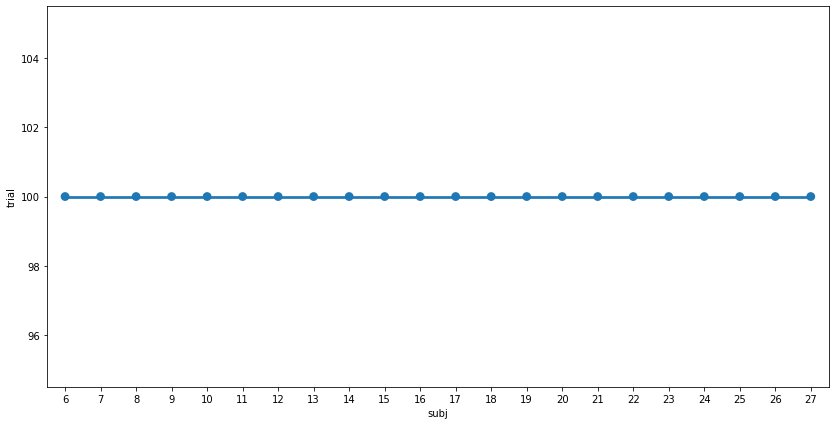

In [12]:
# all subjects have 100 trials
plt.figure(figsize=(14,7))
d=data_df[data_df.practice==False].groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

In [13]:
# remove practice block
data_df = data_df[data_df.block.isin([1,2,3,4])]
# data_df = data_df[data_df.practice==False]

In [14]:
data_df.to_csv('data/behaviour/all_data.csv')

##### Number of different textures

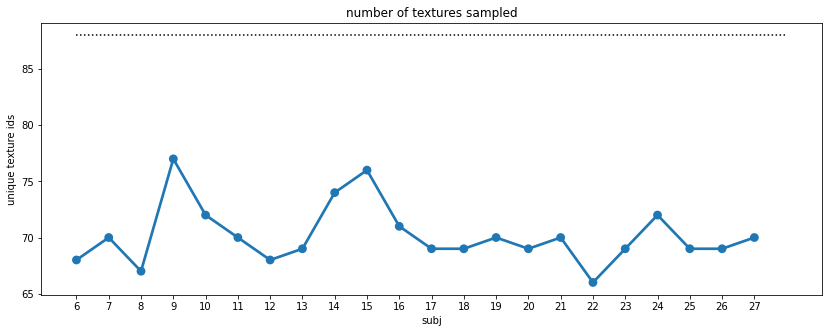

In [15]:
plt.figure(figsize=(14,5))
sns.pointplot(data=data_df.groupby('subj', as_index=False).texture_id.nunique(),
              x='subj',y='texture_id')

plt.title('number of textures sampled')
plt.ylabel('unique texture ids')

plt.plot([0,22],[data_df.texture_id.nunique(),data_df.texture_id.nunique()],'k:')


## Load summary meca data

### Load all data

In [16]:
data_summary = glob.glob("./data/meca/summary/*.xlsx")    
print("got %d summary files"%len(data_summary))
data_df_summary = pd.DataFrame()
for data_sum in data_summary:
    participant_data_summary = pd.read_excel(data_sum,engine="openpyxl")
    data_df_summary = pd.concat([data_df_summary, participant_data_summary], ignore_index=True)
print('dataframe has %d subjects'%data_df_summary.Subject.nunique())

got 9 summary files
dataframe has 23 subjects


In [17]:
data_df_summary


,Date (YYMMDD),Hour [h],Minute [min],Subject,Block,Trial,Texture,Start [s],End [s],Sliding distance [mm],V mean [mm/s],Fn mean [N],Fn std [N],Ft mean [N],Ft std [N],COF mean,COF std,RMS Accelero [m/s²]
0,221122,8,42,16,1,0,1,6.2692,6.8198,37.134524,67.936736,0.244839,0.081262,0.359014,0.075783,1.523927,0.218087,3.381203
1,221122,8,42,16,1,0,2,9.6768,10.3696,37.555220,53.228448,0.354724,0.038919,0.369661,0.026887,1.058695,0.168599,2.619718
2,221122,8,42,16,1,1,1,4.5892,5.2442,32.208557,48.929251,0.510734,0.031468,0.155038,0.012838,0.303306,0.011597,1.254451
3,221122,8,42,16,1,1,2,8.3478,9.2876,35.683789,38.321365,0.378196,0.023547,0.295779,0.043984,0.782811,0.112092,2.044252
4,221122,8,42,16,1,2,1,3.6212,4.4848,35.701824,41.388307,0.464945,0.025050,0.176368,0.016045,0.378981,0.022465,1.067344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,221125,17,18,27,4,22,2,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
4197,221125,17,18,27,4,23,1,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
4198,221125,17,18,27,4,23,2,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
4199,221125,17,18,27,4,24,1,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


### Convert columns names to snake_case

In [18]:
data_df_summary.rename(columns=lambda x: x[0].lower() + x.strip().lower().replace(' ', '_').title()[1:].lower(),inplace=True)  # snake_case
data_df_summary.rename(columns=lambda x: re.sub(r'[^a-z0-9_]', '', x.strip().lower().replace(' ', '_')), inplace=True)

In [19]:
data_df_summary.rename(columns={'subject': 'subj'},inplace=True)

### Sanity checks

<AxesSubplot:xlabel='subj', ylabel='trial'>

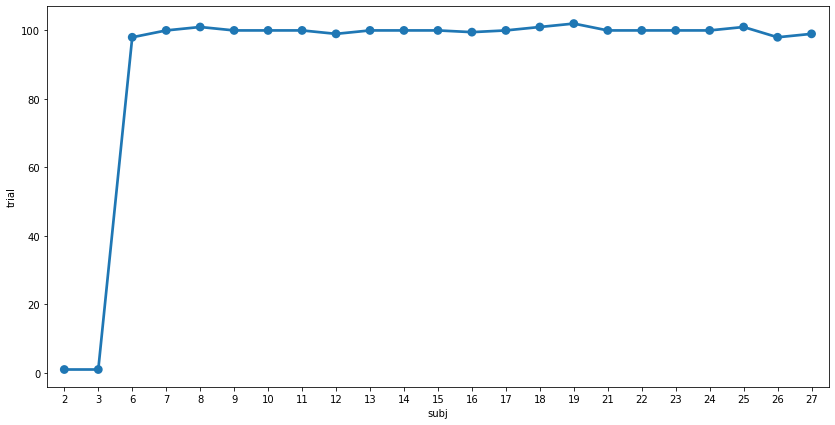

In [20]:
# Trials by subject
plt.figure(figsize=(14,7))
d=data_df_summary.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

#### Remove subjects with not many trials

In [21]:
min_trials = 96  # choix arbitraire proche de 100 
filter = data_df_summary.groupby(['subj']).trial.count()/2 
reliable_subjects= filter[filter > min_trials].index   # get subjects who have more tha min_trials
filtered_df = data_df_summary[data_df_summary['subj'].isin(reliable_subjects)]   # another dataset with reliable_subjects only

In [22]:
filtered_df.groupby(['subj']).trial.count()/2

subj
6      98.0
7     100.0
8     101.0
9     100.0
10    100.0
11    100.0
12     99.0
13    100.0
14    100.0
15    100.0
16     99.5
17    100.0
18    101.0
19    102.0
21    100.0
22    100.0
23    100.0
24    100.0
25    101.0
26     98.0
27     99.0
Name: trial, dtype: float64

<AxesSubplot:xlabel='subj', ylabel='trial'>

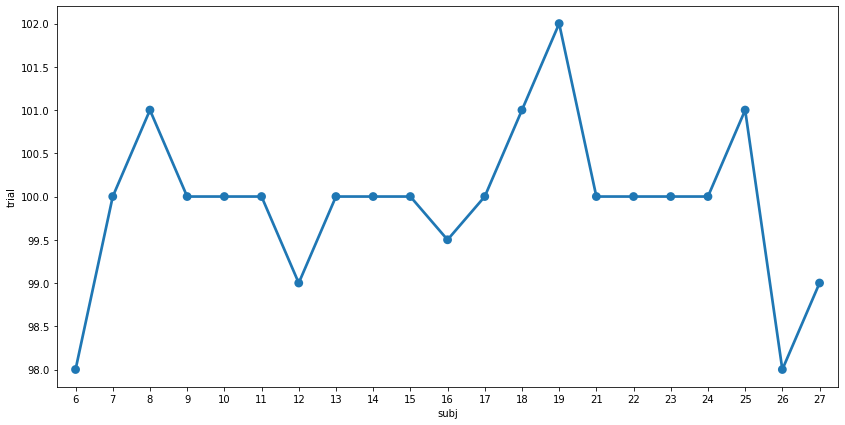

In [23]:
plt.figure(figsize=(14,7))
d=filtered_df.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

### Find duplicates

In [24]:
a = filtered_df.groupby(['subj','block','trial','texture']).subj.count()
a[a>1]

subj  block  trial  texture
6     2      9      1          2
                    2          2
7     1      19     1          2
                    2          2
8     3      13     1          2
                    2          2
15    2      19     1          2
                    2          2
16    2      14     1          2
                    2          2
17    1      18     1          2
                    2          2
      4      3      1          2
                    2          2
18    4      12     1          2
                    2          2
19    2      11     1          2
                    2          2
             22     1          2
                    2          2
21    1      18     1          2
                    2          2
22    1      11     1          2
                    2          2
25    2      0      1          2
                    2          2
             7      1          2
                    2          2
27    1      4      1          3
               

In [25]:
list(filtered_df)

['date_yymmdd',
 'hour_h',
 'minute_min',
 'subj',
 'block',
 'trial',
 'texture',
 'start_s',
 'end_s',
 'sliding_distance_mm',
 'v_mean_mms',
 'fn_mean_n',
 'fn_std_n',
 'ft_mean_n',
 'ft_std_n',
 'cof_mean',
 'cof_std',
 'rms_accelero_ms']

In [26]:
filtered_df2 = filtered_df

filtered_df2 = filtered_df2.groupby(['date_yymmdd',
                       'hour_h',
                       'minute_min',
                       'subj',
                       'block',
                       'trial',
                       'texture'], as_index=False)[['start_s',
                                                    'end_s',
                                                    'sliding_distance_mm',
                                                    'v_mean_mms',
                                                    'fn_mean_n',
                                                    'fn_std_n',
                                                    'ft_mean_n',
                                                    'ft_std_n',
                                                    'cof_mean',
                                                    'cof_std',
                                                    'rms_accelero_ms']].mean().reset_index()



In [27]:
a = filtered_df2.groupby(['subj','block','trial','texture']).subj.count()
a[a>1]

Series([], Name: subj, dtype: int64)

### Find missing trials

In [28]:
missing = [] 
subjects = np.arange(6,28)
subjects = subjects[subjects != 20]
blocks = np.arange(1,5)
trials = np.arange(0,25)
textu = np.arange(1,3)
for i in subjects :
    for j in blocks :
        for n in trials :
            for m in textu :
                f = ( filtered_df['subj'] == i ) & (filtered_df['block'] == j ) & (filtered_df['trial'] == n) &  (filtered_df['texture'] == m)
                if filtered_df[f].empty :
                    missing.append([i,j,n,m])


missing_df = pd.DataFrame(missing, columns=["subj", "block", "trial", "texture"])


In [29]:
pd.set_option('display.max_rows',37)
missing_df

,subj,block,trial,texture
0,6,2,1,1
1,6,2,1,2
2,6,3,10,1
3,6,3,10,2
4,6,4,0,1
5,6,4,0,2
6,7,1,18,1
7,7,1,18,2
8,12,1,19,1
9,12,1,19,2


<AxesSubplot:xlabel='subj', ylabel='trial'>

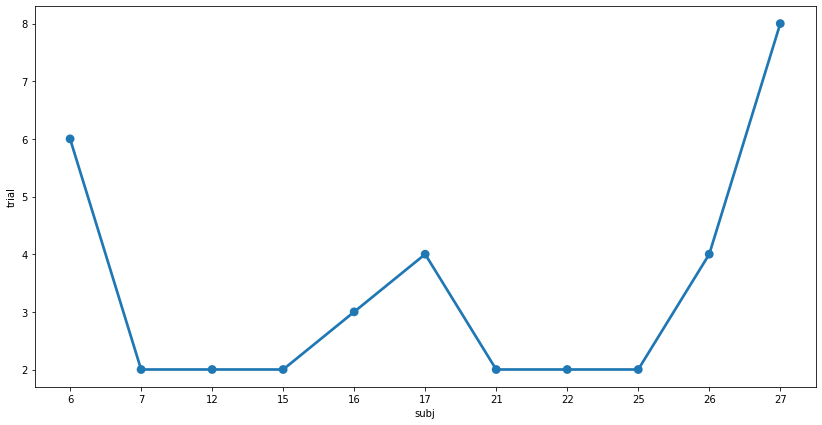

In [30]:
plt.figure(figsize=(14,7))
e=missing_df.groupby(['subj']).trial.count()
sns.pointplot(data=e.reset_index(), x='subj',y='trial')

In [31]:
# Trial qui a une seule texture :
b = missing_df.groupby(['subj','block','trial']).texture.count()
b[b % 2 !=0] 


subj  block  trial
16    2      13       1
Name: texture, dtype: int64

### Outlier values

In [32]:
filtered_df2.iloc[:, filtered_df2.columns.get_loc("sliding_distance_mm"):filtered_df2.columns.get_loc("rms_accelero_ms")].describe()

,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,26.294998,42.057190,0.445305,0.037541,0.347640,0.036842,1.339869,12.054086
std,321.824258,1064.467510,0.463521,0.036763,0.284854,0.034650,5.247461,259.803593
min,-19560.044934,-65254.684509,-0.021901,0.005389,-0.069379,0.000223,-269.963031,0.000503
25%,28.166767,34.460162,0.177712,0.018695,0.160998,0.014207,0.451135,0.027654
50%,33.438019,45.902190,0.358293,0.027266,0.269053,0.026137,0.674465,0.060534
75%,38.600086,57.846558,0.533795,0.043392,0.428918,0.047160,1.235631,0.183048
max,1026.170755,13463.971511,4.890003,0.591267,2.159151,0.425295,93.620329,14313.955103


<AxesSubplot:xlabel='subj', ylabel='v_mean_mms'>

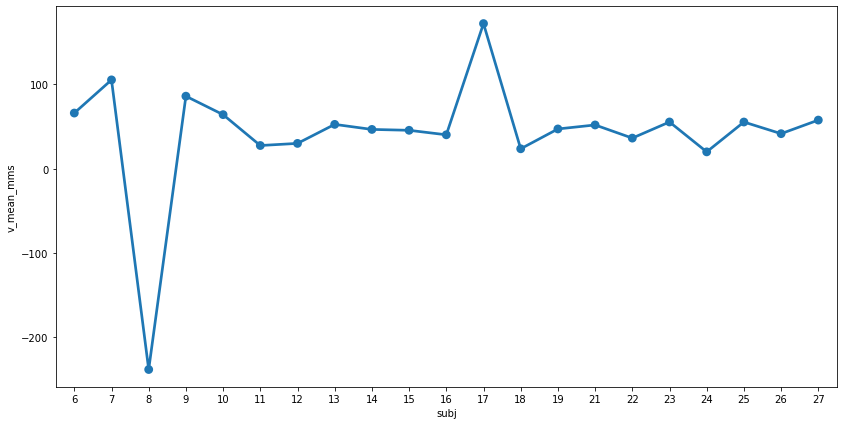

In [33]:
plt.figure(figsize=(14,7))
v_mean_by_subject = filtered_df2.groupby(['subj'])['v_mean_mms'].mean()   # v_mean() for each subject
sns.pointplot(data=v_mean_by_subject.reset_index(), x='subj',y='v_mean_mms')

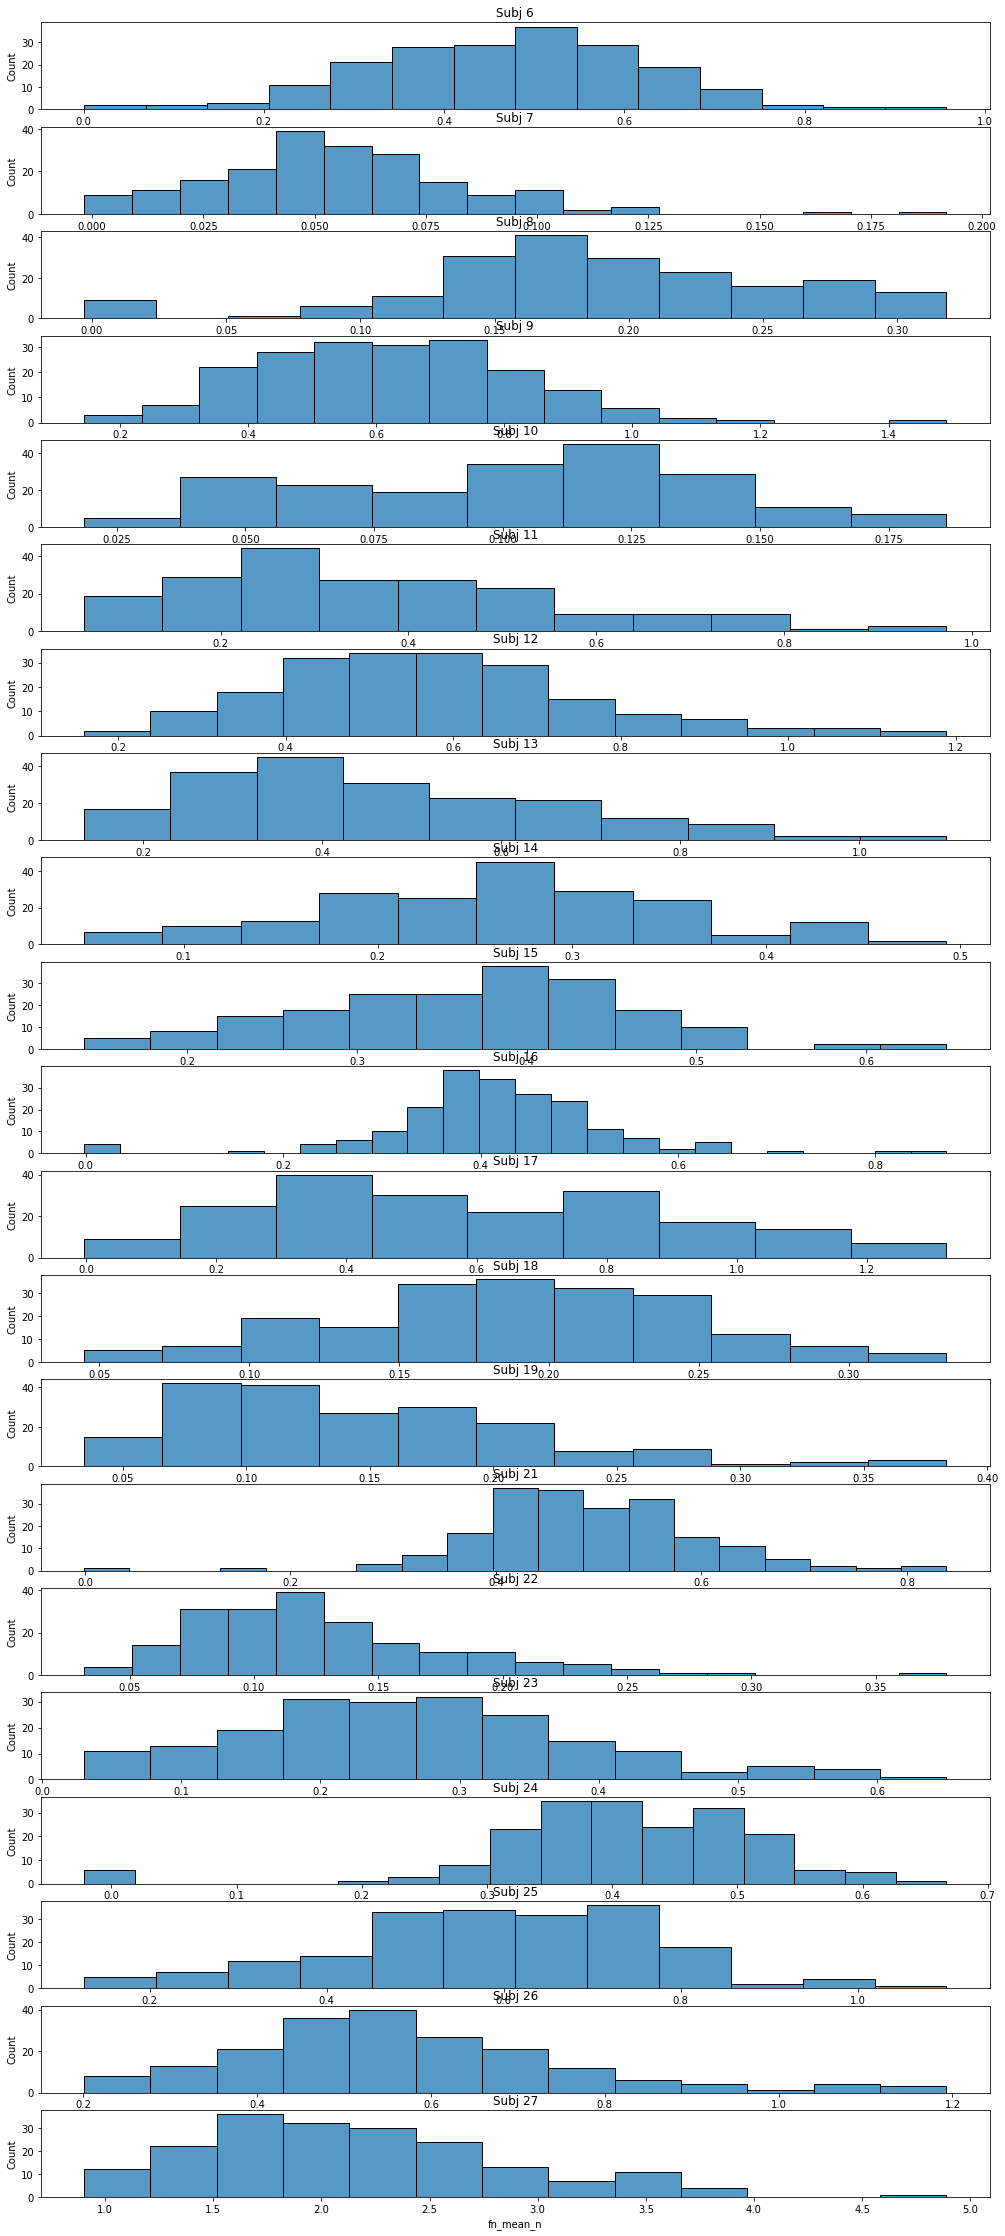

In [34]:
subjs = filtered_df2.subj.unique()  # from 6 to 27
plt.subplots(figsize=(17,40))
for ind, subj in enumerate(subjs): 
    plt.subplot(filtered_df2.subj.nunique(),1,ind+1)  # filtered_df2.subj.nunique() = 21 subplot , 
    sns.histplot(data=filtered_df2[filtered_df2.subj==subj],
                 x='fn_mean_n', label='%s'%subj)
    plt.title('Subj %s'%subj)
    


Text(0.5, 1.0, 'Distribution of sliding distance')

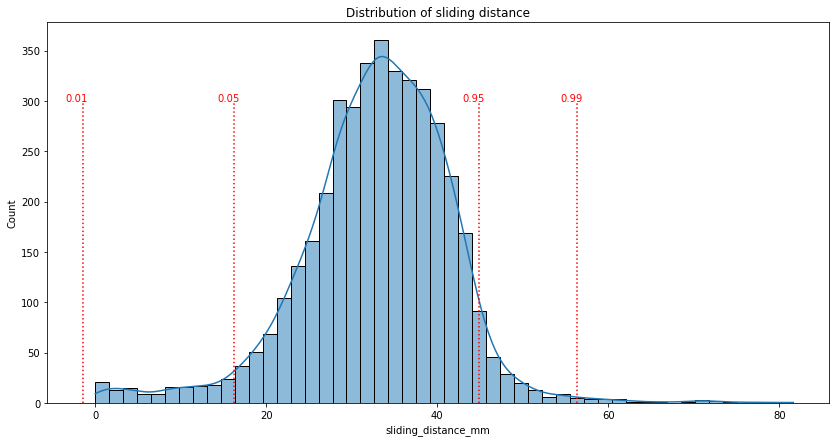

In [35]:
plt.figure(figsize=(14,7))
sns.histplot(data=filtered_df2[(filtered_df2.sliding_distance_mm>0)&
                      (filtered_df2.sliding_distance_mm<100)], x='sliding_distance_mm', bins=50, kde=True)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2.sliding_distance_mm.quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q-2,y_q,'%.2f'%quantile, color='r')
plt.title('Distribution of sliding distance')


Text(0.5, 1.0, 'Distribution of V_mean')

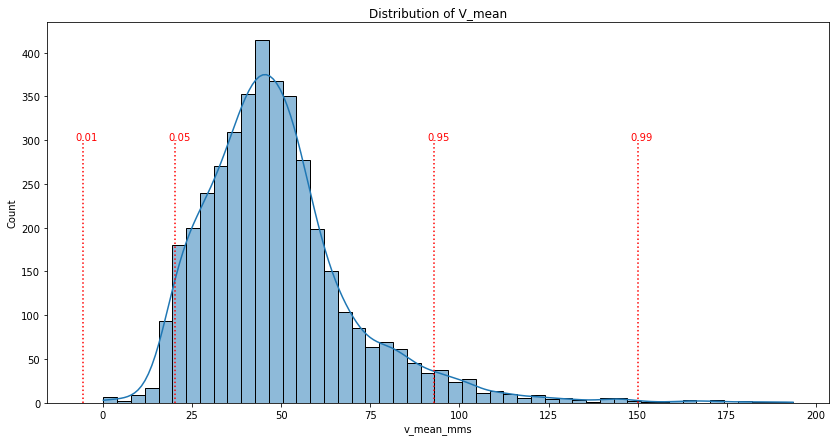

In [36]:
plt.figure(figsize=(14,7))
sns.histplot(data=filtered_df2[(filtered_df2.v_mean_mms>0)& (filtered_df2.v_mean_mms<200)], 
             x='v_mean_mms', bins=50,kde=True)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2.v_mean_mms.quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q-2,y_q,'%.2f'%quantile, color='r')
plt.title('Distribution of V_mean')


Text(0.5, 1.0, 'Distribution of Fn_mean')

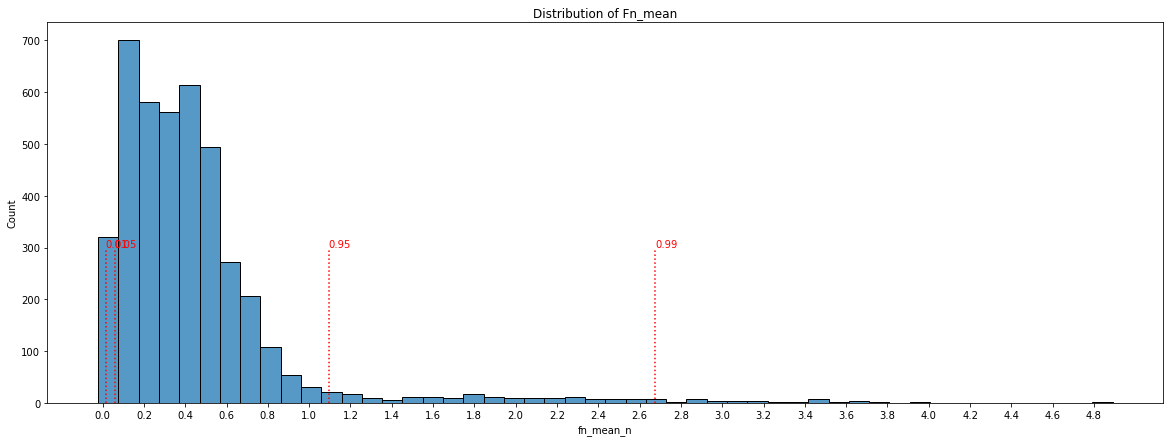

In [37]:
plt.figure(figsize=(20,7))
sns.histplot(data=filtered_df2,#[(df_2.fn_mean_n>0)& (df_2.fn_mean_n<200)], 
             x='fn_mean_n', bins=50)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2.fn_mean_n.quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q,y_q,'%.2f'%quantile, color='r')
plt.xticks(np.arange(0,5,0.2))
plt.title("Distribution of Fn_mean")


Text(0.5, 1.0, 'Distribution of Fn_stf')

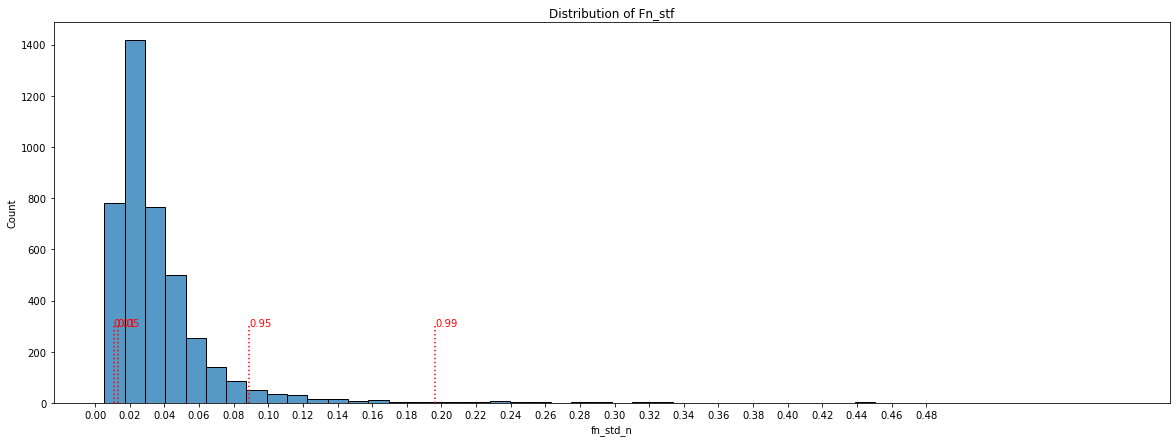

In [38]:
feature = 'fn_std_n'
plt.figure(figsize=(20,7))
sns.histplot(data=filtered_df2,#[(df_2[feature]>0)& (df_2[feature]<1)], 
             x=feature, bins=50)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2[feature].quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q,y_q,'%.2f'%quantile, color='r')
plt.xticks(np.arange(0,0.5,0.02))
plt.title("Distribution of Fn_stf")

Text(0.5, 1.0, 'Distribution of Ft_mean')

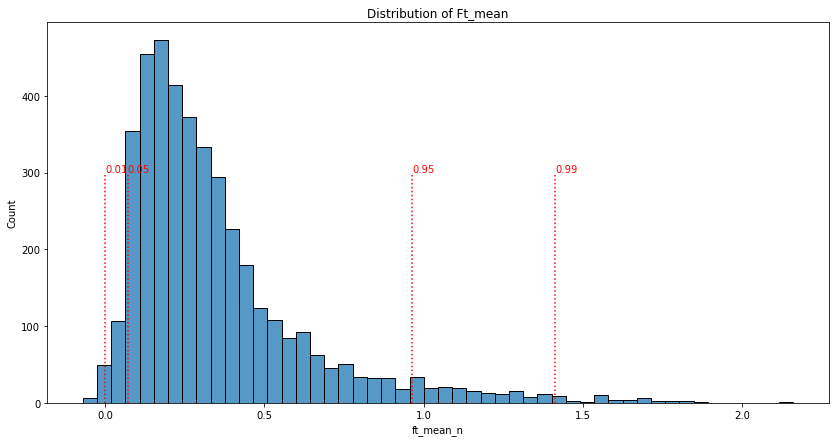

In [39]:
feature = 'ft_mean_n'
plt.figure(figsize=(14,7))
sns.histplot(data=filtered_df2,#[(df_2[feature]>0)& (df_2[feature]<1)], 
             x=feature, bins=50)

quantiles = [0.01, 0.05, 0.95, 0.99]
y_q = 300
for quantile in quantiles: 
    x_q = filtered_df2[feature].quantile(quantile)
    plt.plot([x_q,x_q], [0,y_q],'r:')
    plt.text(x_q,y_q,'%.2f'%quantile, color='r')
plt.title("Distribution of Ft_mean")


#### Filtrer les valeurs outliers

In [40]:
min_values ={'sliding_distance_mm':10,
             'v_mean_mms':0,
              'fn_mean_n':0.05,
             'fn_std_n':0,
             'ft_mean_n':0,
             'ft_std_n':0,
             'cof_mean':0,
             'cof_std':0,
              'rms_accelero_ms':0}   

max_values ={'sliding_distance_mm':70,
             'v_mean_mms':150, 
              'fn_mean_n':2.5,
             'fn_std_n':10,
             'ft_mean_n':2.5,
             'ft_std_n':10,
             'cof_mean':10,
             'cof_std':10,
              'rms_accelero_ms':50}   

mask = True
for column in min_values: 
    column_mask = filtered_df2[column].between(left=min_values[column],
                        right=max_values[column])
    print('Column %s: kept %d/%d (%.2f %%) '%(column.upper(),
                                               column_mask.sum(),
                                               len(column_mask),
                                               100*column_mask.sum()/len(column_mask)))
    mask *= column_mask
    print('\t cumulative: kept %d/%d (%.2f %%) '%(mask.sum(),
                                               len(filtered_df2),
                                               100*mask.sum()/len(filtered_df2)))
    
filtered_df2[mask]


Column SLIDING_DISTANCE_MM: kept 4000/4163 (96.08 %) 
	 cumulative: kept 4000/4163 (96.08 %) 
Column V_MEAN_MMS: kept 4068/4163 (97.72 %) 
	 cumulative: kept 3970/4163 (95.36 %) 
Column FN_MEAN_N: kept 3962/4163 (95.17 %) 
	 cumulative: kept 3837/4163 (92.17 %) 
Column FN_STD_N: kept 4163/4163 (100.00 %) 
	 cumulative: kept 3837/4163 (92.17 %) 
Column FT_MEAN_N: kept 4129/4163 (99.18 %) 
	 cumulative: kept 3834/4163 (92.10 %) 
Column FT_STD_N: kept 4163/4163 (100.00 %) 
	 cumulative: kept 3834/4163 (92.10 %) 
Column COF_MEAN: kept 4077/4163 (97.93 %) 
	 cumulative: kept 3817/4163 (91.69 %) 
Column COF_STD: kept 4091/4163 (98.27 %) 
	 cumulative: kept 3814/4163 (91.62 %) 
Column RMS_ACCELERO_MS: kept 4157/4163 (99.86 %) 
	 cumulative: kept 3808/4163 (91.47 %) 


c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\e

,index,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,0,221110,8,22,6,1,0,1,2.4468,2.9188,27.336514,56.485055,0.101889,0.017506,0.411404,0.077333,4.112849,0.815765,4.338972
2,2,221110,8,22,6,1,1,1,3.2890,3.9926,32.968886,51.992636,0.232339,0.045522,0.284906,0.026106,1.257871,0.175839,2.376460
4,4,221110,8,22,6,1,2,1,2.7382,3.3636,48.907967,63.353527,0.124927,0.017377,0.408266,0.052771,3.309571,0.512267,2.498284
6,6,221110,8,22,6,1,3,1,2.9612,3.4458,35.732360,68.784172,0.295268,0.032018,0.177960,0.027178,0.600501,0.040334,1.157180
8,8,221110,8,22,6,1,4,1,2.4546,3.1166,28.167039,39.146747,0.257821,0.042836,0.367246,0.055283,1.430271,0.092177,1.715674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4158,4158,221125,17,18,27,4,22,2,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
4159,4159,221125,17,18,27,4,23,1,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
4160,4160,221125,17,18,27,4,23,2,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
4161,4161,221125,17,18,27,4,24,1,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


In [41]:
outlier_values = filtered_df2[~mask]
outlier_values

,index,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
1,1,221110,8,22,6,1,0,2,3.6468,4.1268,-1.195209,0.724558,0.374153,0.047508,0.378895,0.048208,1.031406,0.201548,0.349007
3,3,221110,8,22,6,1,1,2,5.2008,5.5466,70.677067,238.470067,0.014616,0.043763,0.023413,0.058613,0.494322,3.759739,0.899553
5,5,221110,8,22,6,1,2,2,3.7298,4.0166,-1.209241,-1.427792,0.528894,0.041373,0.492902,0.038785,0.941459,0.131747,0.270764
7,7,221110,8,22,6,1,3,2,4.0290,4.3712,-1.223049,-1.898012,0.687975,0.113679,0.073072,0.093514,0.084463,0.147489,0.036058
9,9,221110,8,22,6,1,4,2,3.7634,4.1966,-32.441522,11.586621,0.321707,0.230067,0.171209,0.124952,0.893950,11.793635,0.948186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4130,4130,221125,17,18,27,4,7,2,5.5252,6.1598,33.731069,56.872432,2.785975,0.069903,1.872526,0.052615,0.672394,0.020782,1.465334
4141,4141,221125,17,18,27,4,13,1,2.5178,3.3672,29.995917,36.425205,3.284163,0.591267,1.173982,0.283427,0.353522,0.024379,2.689930
4143,4143,221125,17,18,27,4,14,1,3.3276,4.1790,38.823252,45.952937,2.873847,0.131033,1.407756,0.122694,0.489034,0.025007,3.045192
4150,4150,221125,17,18,27,4,17,2,5.6646,6.6204,36.047577,39.548839,1.187908,0.070579,1.576069,0.294561,1.330550,0.259353,97.917783


In [42]:
outlier_values.to_excel('data/meca/out.xlsx')

In [43]:
filtered_df2[mask].to_csv('data/meca/meca.csv')

<mark> 8.5% des essais ont été supprimés

<AxesSubplot:xlabel='subj', ylabel='trial'>

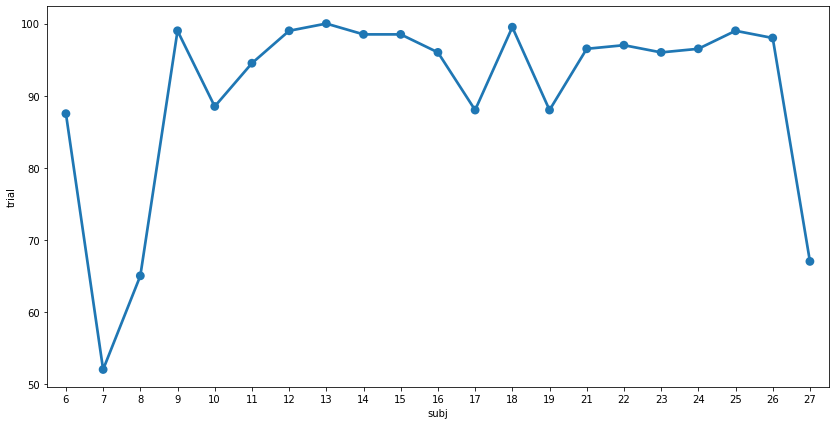

In [44]:
plt.figure(figsize=(14,7))
d=filtered_df2[mask].groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

<AxesSubplot:xlabel='subj', ylabel='trial'>

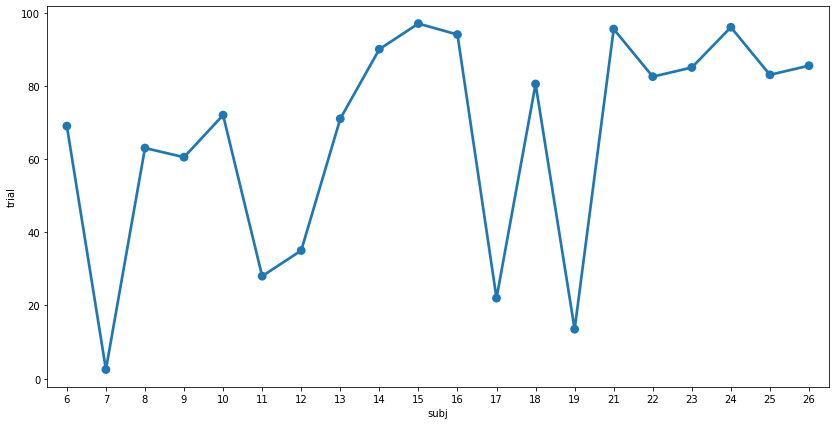

In [ ]:
# Methode des ecart interquartiles IQR :

Q1 = filtered_df2.quantile(0.25)
Q3 = filtered_df2.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#outliers = ((filtered_df2 < lower_bound) | (filtered_df2 > upper_bound)).sum()
filtered_df3 = filtered_df2[~((filtered_df2 < lower_bound) | (filtered_df2 > upper_bound)).any(axis=1)]

plt.figure(figsize=(14,7))
d=filtered_df3.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

## Joindre behavioural data avec summary meca data

In [45]:
data_df.stim_order = data_df.stim_order +1 

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [46]:
filtered_df2.rename(columns={'texture': 'stim_order'}, inplace=True)

In [47]:
df_result = pd.merge(data_df, filtered_df2[mask], on=['subj', 'trial','block','stim_order'], how='inner')

In [48]:
pd.set_option('display.max_columns',df_result.shape[1])
df_result

,subj,trial,block,practice,condition,sex,age,date,data_file,texture_id,stim_order,diameter,opening,spacing,response,rt,index,date_yymmdd,hour_h,minute_min,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
0,6,0,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial0.csv,E030,1,260.0,140.0,400.0,False,10.857,0,221110,8,22,2.4468,2.9188,27.336514,56.485055,0.101889,0.017506,0.411404,0.077333,4.112849,0.815765,4.338972
1,6,1,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial1.csv,E061,1,80.0,170.0,250.0,True,11.883,2,221110,8,22,3.2890,3.9926,32.968886,51.992636,0.232339,0.045522,0.284906,0.026106,1.257871,0.175839,2.376460
2,6,2,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial2.csv,E048,1,170.0,170.0,340.0,False,10.245,4,221110,8,22,2.7382,3.3636,48.907967,63.353527,0.124927,0.017377,0.408266,0.052771,3.309571,0.512267,2.498284
3,6,3,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial3.csv,E069,1,20.0,140.0,160.0,True,9.698,6,221110,8,22,2.9612,3.4458,35.732360,68.784172,0.295268,0.032018,0.177960,0.027178,0.600501,0.040334,1.157180
4,6,4,1,False,soft,f,23,2022-11-10 08:22:05.219727,results/221110_08.22_data_subj6_block1_trial4.csv,E028,1,500.0,260.0,760.0,True,9.379,8,221110,8,22,2.4546,3.1166,28.167039,39.146747,0.257821,0.042836,0.367246,0.055283,1.430271,0.092177,1.715674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803,27,22,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E078(S45),2,80.0,110.0,190.0,False,8.466,4158,221125,17,18,4.7956,5.1706,35.853592,94.943428,1.574174,0.185896,0.564810,0.082925,0.357536,0.012494,6.140435
3804,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E038,1,110.0,80.0,190.0,True,7.617,4159,221125,17,18,2.9734,3.5476,40.110299,73.018695,1.606961,0.068391,0.926973,0.076240,0.576235,0.029874,2.816130
3805,27,23,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E076(S43),2,50.0,50.0,100.0,False,7.617,4160,221125,17,18,5.0852,5.5312,35.825132,85.074553,1.676902,0.030933,0.750410,0.051388,0.447519,0.030270,1.416022
3806,27,24,4,False,rug,m,20,2022-11-25 17:18:05.980838,results/221125_17.18_data_subj27_block4_trial2...,E044,1,170.0,140.0,310.0,True,7.534,4161,221125,17,18,2.6174,3.2676,39.566893,60.739483,1.769655,0.085260,1.102541,0.186779,0.621689,0.096977,4.945476


## Kernel

### Kernel computation

In [49]:
data_melt = pd.melt(data,
        id_vars=['subj','trial','block','sex','age','condition','response'],
        value_vars=['diameter','opening','spacing'],
        var_name='feature')

# z-score feature values
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
# zscore TAS and weights
data_melt['value'] = data_melt.groupby(['subj','feature'])['value'].transform(zscore) 

# compute difference between positives and negatives in each trial
positives = data_melt.loc[data_melt.response == True].reset_index()
negatives = data_melt.loc[data_melt.response == False].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','block','trial','feature'],suffixes=['+','-'])
kernels['delta_value']=kernels['value+']-kernels['value-']

kernels.drop(['index+','response+', 'value+', 
               'index-', 'sex-', 'age-', 'condition-', 'response-', 'value-'], axis=1, inplace=True)
kernels = kernels.rename(columns={'sex+':'sex','age+':'age', 'condition+':'condition'})

# normalize for each subj by dividing by the RMS of their values over all trials 
kernels['square_delta_value'] = kernels['delta_value']**2

for_norm = kernels.groupby(['subj','condition','feature']).agg({'square_delta_value':'mean'}).reset_index()
                                          
kernels = pd.merge(kernels, for_norm, on=['subj','condition','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])

kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)


NameError: name 'data' is not defined

### Different kernels per condition

In [ ]:
kernels.groupby(['condition','feature']).norm_delta_value.mean()

condition  feature 
rug        diameter   -0.006298
           opening     0.613785
           spacing     0.294076
soft       diameter   -0.121706
           opening    -0.510029
           spacing    -0.342440
Name: norm_delta_value, dtype: float64

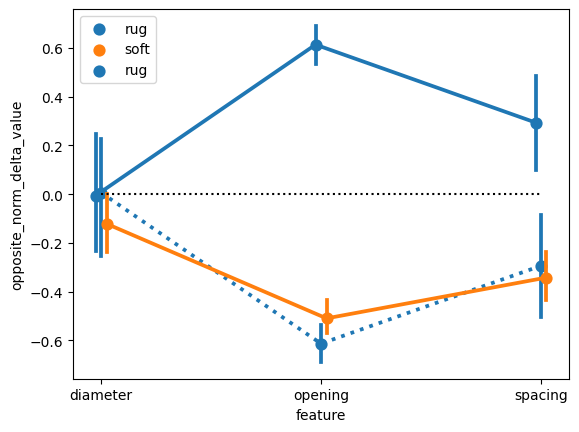

In [ ]:
sns.pointplot(data=kernels,
              hue="condition",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

# plot inverse rough kernel for comparison
kernels['opposite_norm_delta_value'] = - kernels.norm_delta_value
sns.pointplot(data=kernels[kernels.condition=='rug'],
              hue="condition",
             x="feature",
              units='subj',
             y="opposite_norm_delta_value", 
              linestyles=[':'])

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

One-sample difference of kernel weights to zero

In [ ]:
print("One-sample difference of kernel weights to zero")
for condition in ['rug','soft']:
    print('%s:'%condition.upper())
    for feature in ['diameter','opening','spacing']: 
        
        print('- %s'%(feature))
        
        sample = kernels[(kernels.condition==condition)&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
        
        stats= pg.ttest(x=sample.norm_delta_value, y=0)
        print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

One-sample difference of kernel weights to zero
RUG:
- diameter
t(6)=-0.05,p=0.9618
- opening
t(6)=20.43,p=0.0000
- spacing
t(6)=2.70,p=0.0358
SOFT:
- diameter
t(19)=-1.97,p=0.0632
- opening
t(19)=-17.80,p=0.0000
- spacing
t(19)=-6.72,p=0.0000


Two-sample difference of kernel weights between soft and non-rough

In [ ]:
print("Two-sample difference of kernel weights between soft and non-rough")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_soft = kernels[(kernels.condition=='soft')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_rug = kernels[(kernels.condition=='rug')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_soft.norm_delta_value, 
                    y=-sample_rug.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between soft and non-rough
- diameter
t(9)=-0.91,p=0.3853
- opening
t(17)=2.50,p=0.0228
- spacing
t(8)=-0.40,p=0.6976


### Sex difference for soft

In [ ]:
data.groupby(['condition','sex']).subj.nunique()

condition  sex
rug        f       3
           m       4
soft       f      12
           m       8
Name: subj, dtype: int64

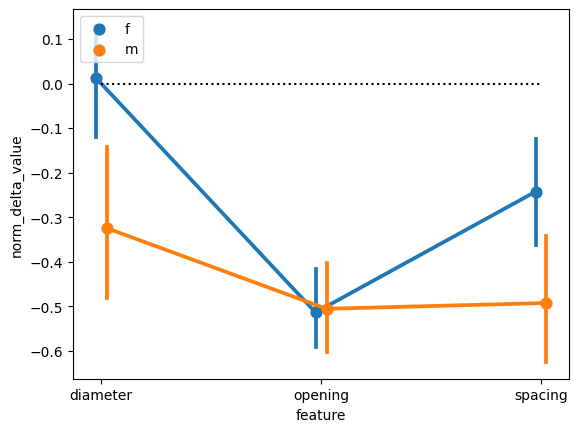

In [ ]:
sns.pointplot(data=kernels[kernels.condition=='soft'],
              hue="sex",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

In [ ]:
print("Two-sample difference of kernel weights between male and female soft")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_male = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='m')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_female = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='f')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_male.norm_delta_value, 
                    y=sample_female.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between male and female soft
- diameter
t(13)=-3.17,p=0.0073
- opening
t(15)=0.14,p=0.8934
- spacing
t(14)=-2.77,p=0.0145


Remember that the first few participants (3 ?) had a bug that resulted in not stopping the recording at the time of response

(-0.01, 0.05)

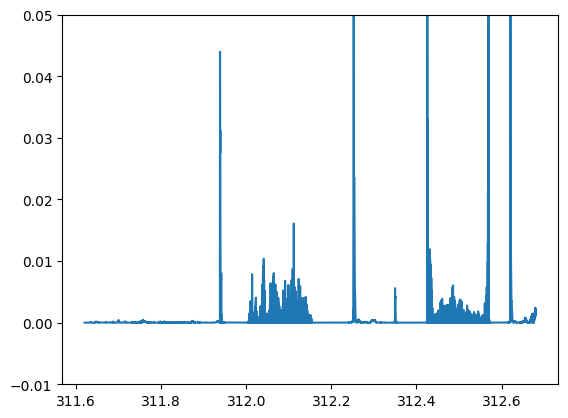